In [1]:
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from tensorflow.keras.layers import Dropout
from keras.callbacks import ModelCheckpoint
from keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping
from keras.applications import MobileNet
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten
from keras.layers import Conv2D,MaxPool2D,GlobalAveragePooling2D,AveragePooling2D
from keras.layers import Input, Flatten,Dense, Dropout
from keras.models import Model

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd 
from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import seaborn as sns
import math

In [2]:
# import tensorflow as tf
# from keras import backend as K

# num_cores = 4
# GPU = 1 
# CPU= 0
# if GPU:
#     num_GPU = 1
#     num_CPU = 1
# if CPU:
#     num_CPU = 1
#     num_GPU = 0

# config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=num_cores,
#                         inter_op_parallelism_threads=num_cores, 
#                         allow_soft_placement=True,
#                         device_count = {'CPU' : num_CPU,
#                                         'GPU' : num_GPU}
#                        )

# session = tf.compat.v1.Session(config=config)
# K.set_session(session)

In [3]:
# import keras

# config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 56} )
# sess = tf.Session(config=config) 
# keras.backend.set_session(sess)

In [4]:
# Splitting images Train/Val/Test

# import split_folders
# # Split with a ratio.
# # To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
# split_folders.ratio('dataset/cam1', output="dataset/prueba", seed=45, ratio=(.7, .15, .15)) # default values

In [5]:
base_dir = 'dataset/all_cameras_splitted'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'Val')

# Directory with our training pictures
train_OK_dir = os.path.join(train_dir, 'OK')
train_NOT_OK_dir = os.path.join(train_dir, 'NOT_OK')

# Directory with our validation pictures
validation_OK_dir = os.path.join(validation_dir, 'OK')
validation_NOT_OK_dir = os.path.join(validation_dir, 'NOT_OK')
train_OK_fnames = os.listdir( train_OK_dir )
train_NOT_OK_fnames = os.listdir( train_NOT_OK_dir )

# print(train_cat_fnames[:10])
# print(train_dog_fnames[:10])



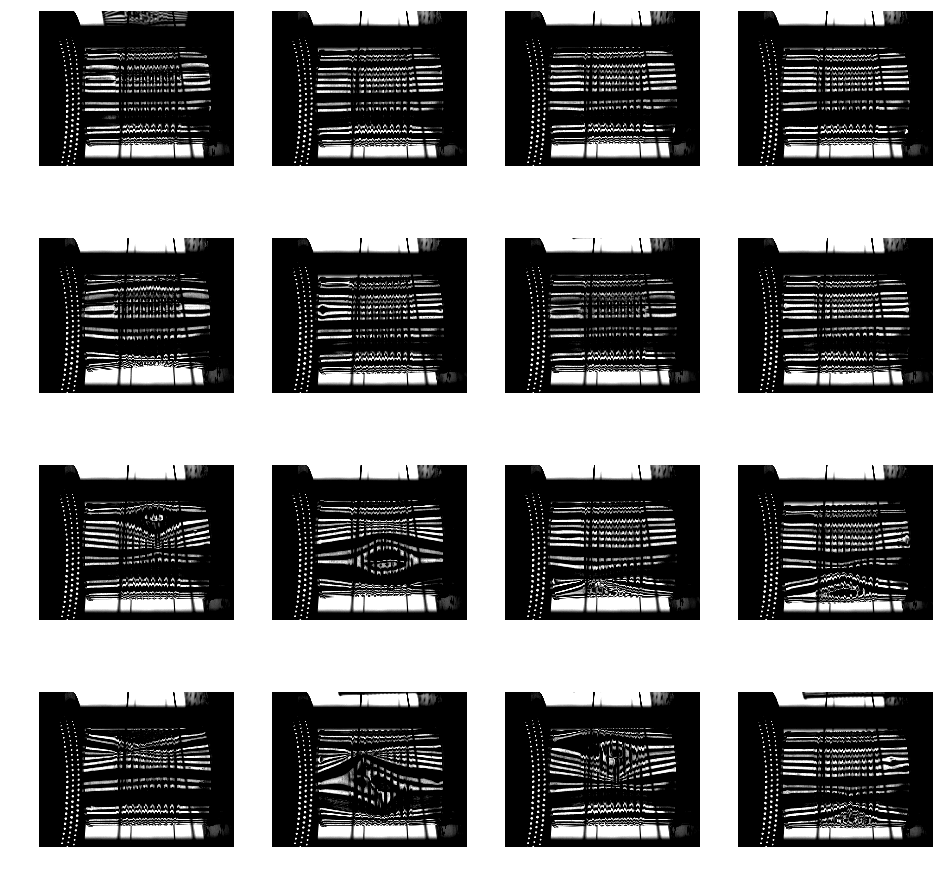

In [6]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_OK_pix = [os.path.join(train_OK_dir, fname) 
                for fname in train_OK_fnames[ pic_index-8:pic_index] 
               ]

next_NOT_OK_pix = [os.path.join(train_NOT_OK_dir, fname) 
                for fname in train_NOT_OK_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_OK_pix+next_NOT_OK_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
#   print(img.shape)  
  plt.imshow(img, 'gray')

In [7]:
with tf.device('/cpu:0'):
    # All images will be rescaled by 1./255.
    train_datagen = ImageDataGenerator(
          rescale=1/255,
    #       rotation_range=40,
          width_shift_range=0.1,
          height_shift_range=0.1,
    #       fill_mode='nearest',
    #       shear_range=0.2,
    #       zoom_range=0.2,
          horizontal_flip=True
    )

    test_datagen = ImageDataGenerator(rescale=1/255)
    train_generator = train_datagen.flow_from_directory(
            train_dir,  # This is the source directory for training images

            ### En esta linea de codigo se cambia el tamaño de la imagen

            target_size=(224,224),  # All images will be resized 

            ####

            batch_size=256,
            # Since we use binary_crossentropy loss, we need binary labels
            class_mode='binary')
    # Flow training images in batches of 128 using train_datagen generator
    validation_generator = test_datagen.flow_from_directory(
            validation_dir,  # This is the source directory for training images

            ##Tamaño de imagen del validation dataset


            target_size=(224,224),  # All images will be resized 
            ###


            batch_size=256,
            # Since we use binary_crossentropy loss, we need binary labels
            class_mode='binary')

Found 16761 images belonging to 2 classes.
Found 3351 images belonging to 2 classes.


In [8]:
print(train_generator.samples)
print(train_generator.class_indices)

16761
{'NOT_OK': 0, 'OK': 1}


In [9]:
x,y = next(train_generator)
print(x.shape)
print(y.shape)
print(type(x))
print(type(y))

(256, 224, 224, 3)
(256,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [10]:
y_int= y.tolist()

In [11]:
# from mpl_toolkits.axes_grid1 import ImageGrid
# def show_grid(image_list,nrows,ncols,label_list=None,show_labels=False,savename=None,figsize=(10,10),showaxis='off'):
#     if type(image_list) is not list:
#         if(image_list.shape[-1]==1):
#             image_list = [image_list[i,:,:,0] for i in range(image_list.shape[0])]
#         elif(image_list.shape[-1]==3):
#             image_list = [image_list[i,:,:,:] for i in range(image_list.shape[0])]
#     fig = plt.figure(None, figsize,frameon=False)
#     grid = ImageGrid(fig, 111,  # similar to subplot(111)
#                      nrows_ncols=(nrows, ncols),  # creates 2x2 grid of axes
#                      axes_pad=0.3,  # pad between axes in inch.
#                      share_all=True,
#                      )
#     for i in range(nrows*ncols):
#         ax = grid[i]
#         ax.imshow(image_list[i],cmap='Greys_r')  # The AxesGrid object work as a list of axes.
#         ax.axis('off')
#         if show_labels:
# #             ax.set_title(class_mapping[y_int[i]])
#              ax.set_title(y_int[i])
#     if savename != None:
#         plt.savefig(savename,bbox_inches='tight')

In [12]:
# show_grid(x,4,8,label_list=y_int,show_labels=True,figsize=(20,10),savename='.image_grid.png')

In [13]:
# def plots(ims, figsize=(12,6), rows=3, interp=False, titles=None):
#     if type(ims[0]) is np.ndarray:
#         ims = np.array(ims).astype(np.uint8)
#         if (ims.shape[-1] != 3):
#             ims = ims[:, :, ::-1]
            
#     f = plt.figure(figsize=figsize)
#     cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
#     for i in range(len(ims)):
#         sp = f.add_subplot(rows, cols, i+1)
#         sp.axis('Off')
#         if titles is not None:
#             sp.set_title(titles[i], fontsize=16)
#             ims[i] = np.reshape(ims[i],((128,128)))
#         plt.imshow(ims[i], interpolation=None if interp else 'none')
# #         print(ims[i].shape)
# imgs, labels = next(train_generator)

# plots(imgs)

In [14]:
# train_generator.samples

In [15]:
# output = restnet.layers[-1].output
# output = keras.layers.Flatten()(output)
# restnet = Model(restnet.input, output=output)

In [16]:

def create_new_model():
    base_model=MobileNet(weights='imagenet',include_top=False,input_shape=(224,224,3)) #imports the mobilenet model and discards the last 1000 neuron layer.

    x=base_model.output
    x=GlobalAveragePooling2D()(x)
    x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
    x = Dropout(0.5)(x)
    x=Dense(1024,activation='relu')(x) #dense layer 2
    x = Dropout(0.4)(x)
    x=Dense(512,activation='relu')(x) #dense layer 3
    x = Dropout(0.3)(x)
    preds=Dense(1,activation='sigmoid')(x) #final layer with softmax activation
    model=Model(inputs=base_model.input,outputs=preds)

    for layer in model.layers:
        layer.trainable=True
    # or if we want to set the first 20 layers of the network to be non-trainable
    for layer in model.layers[:20]:
        layer.trainable=False
    for layer in model.layers[20:]:
        layer.trainable=True

    for layer in model.layers:
        if "BatchNormalization" in layer.__class__.__name__:
            layer.trainable = True
    return model

In [17]:
model = create_new_model()

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

In [19]:
# for i,layer in enumerate(model.layers):
#     print(i,layer.name)

In [20]:
# for layer in model.layers:
#     layer.trainable=True
# # or if we want to set the first 20 layers of the network to be non-trainable
# for layer in model.layers[:20]:
#     layer.trainable=False
# for layer in model.layers[20:]:
#     layer.trainable=True
    
# for layer in model.layers:
#     if "BatchNormalization" in layer.__class__.__name__:
#         layer.trainable = True

In [21]:
# for i, layer in enumerate(model.layers):
#         print(i, layer.name, layer.trainable)

In [22]:
# from keras.applications import MobileNet
# with tf.device('/cpu:0'):
#     MobileNet = MobileNet(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

In [23]:
# MobileNet.summary()

In [24]:
# # Freeze four convolution blocks
# with tf.device('/cpu:0'):
#     for layer in res_model.layers[:201]:
#         layer.trainable = False# Make sure you have frozen the correct layers
#     for i, layer in enumerate(res_model.layers):
#         print(i, layer.name, layer.trainable)

In [25]:

# with tf.device('/cpu:0'):
#     x = res_model.output
#     x = Flatten()(x) # Flatten dimensions to for use in FC layers
#     # x = Dense(1024, activation='relu')(x)
#     # x = Dropout(0.5)(x) # Dropout layer to reduce overfitting
#     x = Dense(1024, activation='relu')(x)
#     x = Dense(256, activation='relu')(x)
#     x = Dense(64, activation='relu')(x)
#     x = Dense(1, activation='softmax')(x) 
#     transfer_model = Model(inputs=res_model.input, outputs=x)

In [26]:
# gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)
# session = tf.compat.v1.InteractiveSession(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

In [27]:
# transfer_model.summary()

In [28]:
# classifier.summary()

In [29]:
# with tf.device('/cpu:0'):
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])

In [ ]:
with tf.device('/cpu:0'):

    filepath="12_mobile_net_transfer_weights_improvement-{epoch:02d}-{val_accuracy:.2f}.h5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

    reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', mode="max", factor = 0.7, 
         patience = 2, verbose = 1, min_delta =0.00001)
    early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, mode='auto')

    callbacks = [reduce_lr,checkpoint,early_stop]

    batch_size = 256

    history = model.fit(train_generator,
                                       steps_per_epoch = math.ceil(train_generator.samples//batch_size),
                                  validation_data=validation_generator,  
                                       validation_steps=math.ceil(validation_generator.samples//batch_size),
                                  epochs=100,workers=-1, 
                                use_multiprocessing=True, shuffle=True, callbacks=callbacks
                                  )

Epoch 1/100
65/65 [==============================] - 3402s 52s/step - loss: 0.4720 - accuracy: 0.7964 - val_loss: 1.6166 - val_accuracy: 0.7897

Epoch 00001: val_accuracy improved from -inf to 0.78966, saving model to 12_mobile_net_transfer_weights_improvement-01-0.79.h5
Epoch 2/100
65/65 [==============================] - 3151s 49s/step - loss: 0.2295 - accuracy: 0.9077 - val_loss: 0.4147 - val_accuracy: 0.8954

Epoch 00002: val_accuracy improved from 0.78966 to 0.89543, saving model to 12_mobile_net_transfer_weights_improvement-02-0.90.h5
Epoch 3/100
65/65 [==============================] - 3136s 48s/step - loss: 0.2001 - accuracy: 0.9206 - val_loss: 1.7152 - val_accuracy: 0.7572

Epoch 00003: val_accuracy did not improve from 0.89543
Epoch 4/100
65/65 [==============================] - 3164s 49s/step - loss: 0.1780 - accuracy: 0.9317 - val_loss: 0.4192 - val_accuracy: 0.8759

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.

Epoch 00004: val_accuracy d

In [ ]:
# classifier.save('model3.h5')

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()